# Задание

Набор данных ex6data1.mat представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит две переменные X1 и X2 - координаты точек, которые необходимо кластеризовать.  
Набор данных bird_small.mat представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит массив размером (16384, 3) - изображение 128x128 в формате RGB.  


1. Загрузите данные ex6data1.mat из файла.
2. Реализуйте функцию случайной инициализации K центров кластеров.
3. Реализуйте функцию определения принадлежности к кластерам.
4. Реализуйте функцию пересчета центров кластеров.
5. Реализуйте алгоритм K-средних.
6. Постройте график, на котором данные разделены на K=3 кластеров (при помощи различных маркеров или цветов), а также траекторию движения центров кластеров в процессе работы алгоритма
7. Загрузите данные bird_small.mat из файла.
8. С помощью алгоритма K-средних используйте 16 цветов для кодирования пикселей.
9. Насколько уменьшился размер изображения? Как это сказалось на качестве?
10. Реализуйте алгоритм K-средних на другом изображении.
11. Реализуйте алгоритм иерархической кластеризации на том же изображении. Сравните полученные результаты.

In [1]:
import cv2
import numpy  as np
from scipy.io import loadmat
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import heapq
%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
X = loadmat('Data/Lab 6/ex6data1.mat')['X']

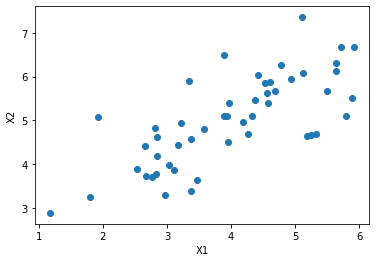

In [4]:
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [5]:
def l2_dist(x, y, axis=1):
    return np.sqrt(np.sum((x - y) ** 2, axis=axis))


def normalize(X):
    mean, std = X.mean(), X.std()
    return (X - mean) / std, mean, std


def random_centers(X, k):
    X_uniq = np.unique(X, axis=0)
    rand_idx = np.random.permutation(len(X_uniq))
    return X_uniq[rand_idx[:k]]


def assign_centers(X, centers):
    centr_dist = np.array([l2_dist(X, c) for c in centers])
    return np.argmin(centr_dist, axis=0)


def update_centers(X, labels):
    k = labels.max() + 1
    return np.array([np.mean(X[labels == i], axis=0) for i in range(k)])


def kmeans(X, k, max_iters=1000):
    history = []
    centers = None
    X_norm, X_mean, X_std = normalize(X)
    
    for i in range(max_iters):
        centers = update_centers(X_norm, labels) if i else random_centers(X_norm, k)
        labels = assign_centers(X_norm, centers)

        if history and np.all(history[-1][1] == labels):
            break
        
        orig_centres = centers * X_std + X_mean
        history.append((orig_centres, labels))
        
    return history

In [6]:
history = kmeans(X, k=3)

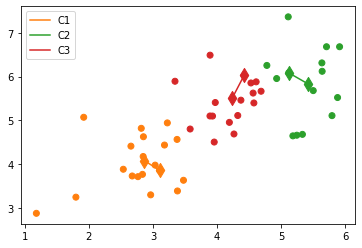

In [7]:
colors = ['C1', 'C2', 'C3']
plt.scatter(X[:, 0], X[:, 1], c=[colors[x] for x in history[-1][1]])

for centers, labels in history:
    for center, color in zip(centers, colors):
        plt.scatter(center[0], center[1], c=color, marker='d', s=100)
        
for i in range(3):
    trajectory = np.array([centers[i] for centers, _ in history])
    plt.plot(trajectory[:, 0], trajectory[:, 1], c=colors[i], label=colors[i])
    
plt.legend()
plt.show()

In [8]:
bird = loadmat('Data/Lab 6/bird_small.mat')['A']

In [9]:
def cluster_image_kmeans(img, k=16):
    history = kmeans(img.reshape(-1, 3), k)
    centers, labels = history[-1]
    reduced_colors = np.uint8(centers)
    reduced_img = np.reshape([reduced_colors[x] for x in labels], img.shape)
    
    return reduced_img

In [10]:
bird_kmeans = cluster_image_kmeans(bird)

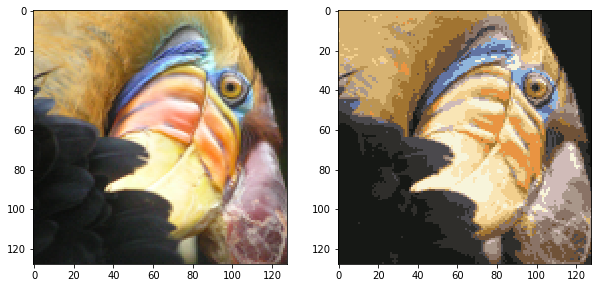

In [11]:
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(bird)
plt.subplot(122)
plt.imshow(bird_kmeans)
plt.show()

In [12]:
cv2.imwrite('Data/Lab 6/bird.png', cv2.cvtColor(bird, cv2.COLOR_RGB2BGR))
cv2.imwrite('Data/Lab 6/bird_kmeans.png', cv2.cvtColor(bird_kmeans, cv2.COLOR_RGB2BGR))

True

In [13]:
!ls Data/Lab\ 6/*bird*.png

Data/Lab 6/bird.png        Data/Lab 6/bird_kmeans.png


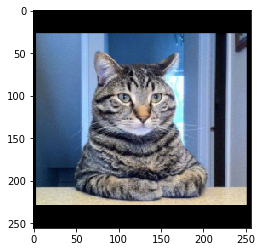

In [26]:
cat = cv2.imread('Data/Lab 6/cat_small.png')
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)

plt.imshow(cat)
plt.show()

In [27]:
cat_kmeans = cluster_image_kmeans(cat)

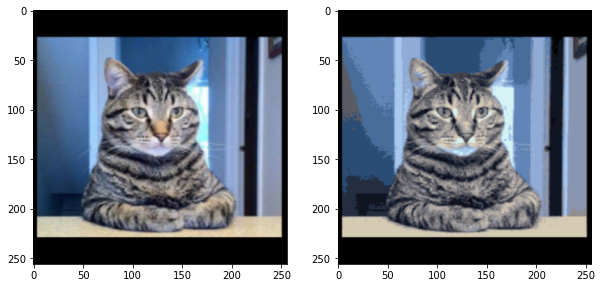

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(cat, interpolation='bicubic')
plt.subplot(122)
plt.imshow(cat_kmeans, interpolation='bicubic')
plt.show()

In [17]:
cv2.imwrite('Data/Lab 6/cat_small_kmeans.png', cv2.cvtColor(cat_kmeans, cv2.COLOR_RGB2BGR))

True

In [18]:
!ls Data/Lab\ 6/*cat_small*.png

Data/Lab 6/cat_small.png        Data/Lab 6/cat_small_kmeans.png


In [19]:
def calc_initial_dist(X):
    # Using efficient implementation from scipy
    dist = distance_matrix(X, X)
    idx = np.arange(len(X))
    dist[idx, idx] = 10 ** 3
    
    return dist


def update_dist(u, v, clusters, dist, heap):        
    for s in clusters.keys():
        if s == u:
            continue

        # Using Lance-Williams formula for complete-linkage (http://neerc.ifmo.ru/wiki/index.php?title=Иерархическая_кластеризация)
        d_su = (dist[u, s] + dist[v, s] + abs(dist[u, s] - dist[v, s])) / 2
        dist[s, u] = dist[u, s] = d_su
        heapq.heappush(heap, (d_su, u, s))
    
    dist[v, :] = dist[:, v] = 10 ** 3


def build_heap(dist, clusters):
    clist = list(clusters.keys())
    n = len(clist)
    # Heap consists of tuples (d_uv, u, v), wher u, v - clusters, d_uv - distance between them
    heap = [(dist[clist[i], clist[j]], clist[i], clist[j]) 
            for i in range(n) for j in range(i + 1)]
    heapq.heapify(heap)
    
    return heap
    
    
def find_closest_clusters(heap, clusters):
    while True:
        # Using heap to find min distance and closest clusters
        d, u, v = heapq.heappop(heap)
        # Check if u and v are in the set of current clusters
        # because old distances are not removed from the heap
        # and we can get a cluster that already has been merged
        if u in clusters and v in clusters:
            return (u, v)


def hierarchical_clustering(X, k):
    # Distance matrix
    dist = calc_initial_dist(X)
    n = len(X)
    # Set of current clusters
    clusters = {i: [i] for i in range(n)}
    heap = build_heap(dist, clusters)
    
    for i in tqdm_notebook(range(n - k)):
        u, v = find_closest_clusters(heap, clusters)
        # Merge v in to u and delete u
        clusters[u].extend(clusters[v])
        del clusters[v]
        # Update distances
        update_dist(u, v, clusters, dist, heap)
        # Rebuild heap as it accumulates too much old distances
        if i > 0 and i % int(0.7 * n) == 0:
            heap = build_heap(dist, clusters)
    
    labels = {x:i for i, c in enumerate(clusters.values()) for x in c}
    labels = np.array([x[1] for x in sorted(labels.items())])
    
    return labels

In [20]:
X_labels = hierarchical_clustering(X, k=3)

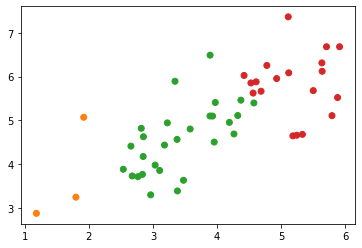

In [21]:
colors = ['C1', 'C2', 'C3']
plt.scatter(X[:, 0], X[:, 1], c=[colors[x] for x in X_labels])
plt.show()

In [22]:
def cluster_image_hierarchical(img, k):
    X = img.reshape(-1, 3)
    X_uniq = np.unique(X, axis=0)
    X_uniq_norm, _, _ = normalize(X_uniq)
    
    labels_uniq = hierarchical_clustering(X_uniq_norm, k=16)
    
    label_mapping = {tuple(x): l for x, l in zip(X_uniq, labels_uniq)}
    labels = np.array([label_mapping[tuple(x)] for x in X])
    reduced_colors = np.array([np.mean(X[labels == i], axis=0).astype(np.uint8) for i in range(k)])
    reduced_img = np.reshape([reduced_colors[x] for x in labels], img.shape)
    
    return reduced_img

In [30]:
cat_small = cv2.resize(cat, (96, 96), cv2.INTER_NEAREST)
cat_hierarchical = cluster_image_hierarchical(cat_small, k=16)

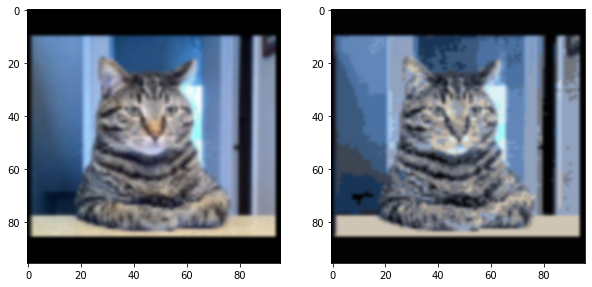

In [31]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(cat_small, interpolation='bicubic')
plt.subplot(122)
plt.imshow(cat_hierarchical, interpolation='bicubic')
plt.show()